# Check how LLI to SEI change when save_at_cycles

In [14]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

In [16]:
model = pb.lithium_ion.DFN(
    options={
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",} )
param = pb.ParameterValues("OKane2023")
# param.update({"Negative electrode porosity": 0.1})
# Adjust SEI parameters
param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 3e-19})
param.update({"EC partial molar volume [m3.mol-1]": 5e-5})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1e-6})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1e-10})
# Adjust mechanical degradation parameters
param.update({"Negative electrode cracking rate": 1e-20})
param.update({"Negative electrode LAM constant proportional term [s-1]": 1e-19})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-19})

c_e = model.variables["Electrolyte concentration [mol.m-3]"]
T = model.variables["Cell temperature [K]"]
D_e = model.param.D_e
kappa_e = model.param.kappa_e
model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e, T)
model.variables["Electrolyte conductivity [S.m-1]"] = kappa_e(c_e, T)
V_max = 4.2;        V_min = 2.5; Update_Cycles = 4
discharge_time_mins = 0.15* 60 * 4.86491/5
charge_time_mins = 0.5* 60 * 4.86491/5
exp_AGE_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] 
Experiment_Long   = pb.Experiment( exp_AGE_text * Update_Cycles  )
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}


In [17]:
# CasadiSolver
param.update({"Electrolyte conductivity [S.m-1]": electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Thermodynamic factor": electrolyte_TDF_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Cation transference number": electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant})
sim = pb.Simulation(
    model, 
    experiment=Experiment_Long,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol = sim.solve(
    calc_esoh=False,
    save_at_cycles = Update_Cycles,
)

At t = 1301.89 and h = 3.54934e-13, the corrector convergence failed repeatedly or with |h| = hmin.
2023-05-24 11:47:41.709 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Could not find consistent states: Could not find acceptable solution: Error in Function::call for 'roots' [Newton] at .../casadi/core/function.cpp:330:
.../casadi/core/rootfinder.cpp:277: rootfinder process failed. Set 'error_on_fail' option to false to ignore this error.


In [18]:
sol.cycles[0]["Loss of capacity to SEI [A.h]"].entries

array([0.00000000e+00, 8.22751469e-08, 1.63682975e-07, 2.44527204e-07,
       3.24872272e-07, 4.04782824e-07, 4.84319204e-07, 5.63535104e-07,
       6.27372652e-07, 6.27372652e-07, 1.88407748e-06, 3.13803535e-06,
       4.39112364e-06, 4.39112364e-06, 5.73940665e-06, 7.03328771e-06,
       8.22310780e-06, 9.16614927e-06, 9.86494352e-06, 1.04050732e-05,
       1.07783500e-05, 1.10436172e-05, 1.12867273e-05, 1.15107178e-05,
       1.17090190e-05, 1.18705506e-05, 1.19775410e-05, 1.20240927e-05,
       1.20406704e-05, 1.20465960e-05, 1.20486367e-05, 1.20486935e-05,
       1.20486939e-05, 1.20486939e-05, 1.20486939e-05, 1.20486939e-05,
       1.20486939e-05, 1.20486939e-05, 1.20486939e-05, 1.20486939e-05,
       1.20486939e-05, 1.20486939e-05, 1.20486939e-05, 1.20486939e-05,
       1.20486939e-05, 1.20512730e-05, 1.20636254e-05, 1.20887754e-05,
       1.21691448e-05, 1.23643205e-05, 1.27345559e-05, 1.32696725e-05,
       1.38748959e-05, 1.45326704e-05, 1.53166098e-05, 1.65635879e-05,
      

LAM_ne [%]
LAM_pe [%]


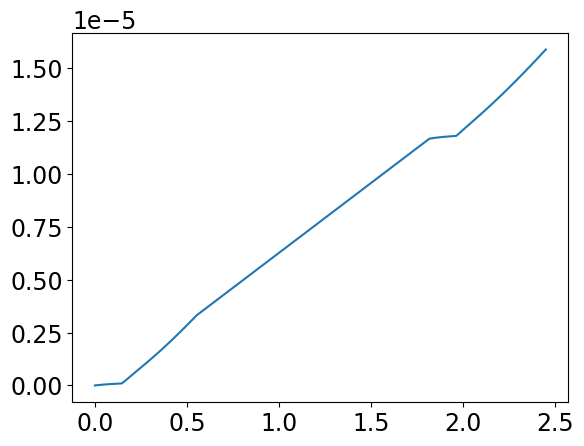

In [13]:
model.variables.search("LAM")
plt.plot(
    sol["Time [h]"].entries-sol["Time [h]"].entries[0],
    #sol_C_10.cycles[1].steps[0]["Terminal voltage [V]"].entries
    sol["Loss of capacity to SEI [A.h]"].entries
    #sol_C_10.cycles[1].steps[0]["Current [A]"].entries
    )

Total data points:  128
Applied current [A]: 2.5
Total data points:  87
Applied current [A]: 0.5


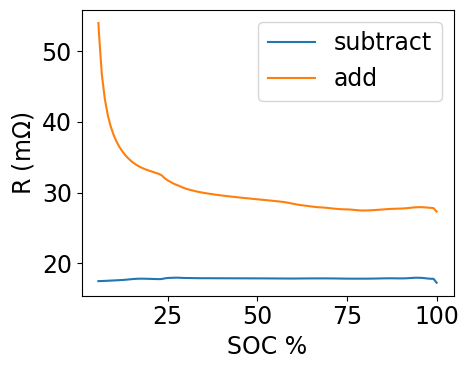

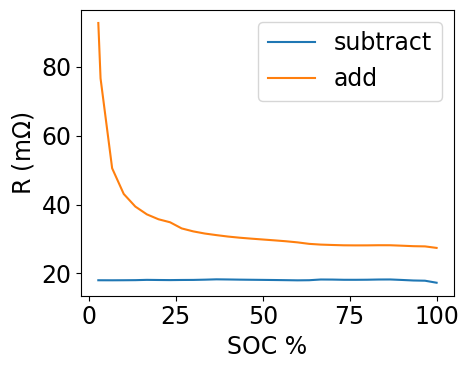

In [9]:
# Get R during constant discharge (no matter what current rate is) 
# at the right SOC

def Get_R_from_Constant_Discharge(sol_C_2,cyc_no,cap_full):
    print("Total data points: ",len(sol_C_2.cycles[1]["Time [h]"].entries))
    cycle = sol_C_2.cycles[cyc_no]
    Dis_Cap = abs(
        cycle.steps[0]["Discharge capacity [A.h]"].entries[0] 
        - cycle.steps[0]["Discharge capacity [A.h]"].entries )
    SOC_CD = (1-Dis_Cap/cap_full)*100
    #print(SOC_CD)
    V_ohmic = (
    cycle.steps[0]['Battery open-circuit voltage [V]'].entries 
    - cycle.steps[0]["Terminal voltage [V]"].entries

    + cycle.steps[0]["Battery particle concentration overpotential [V]"].entries 
    + cycle.steps[0]["X-averaged battery concentration overpotential [V]" ].entries
    #+ cycle.steps[0]["X-averaged battery reaction overpotential [V]" ].entries
    )#
    """ V_ohmic_2 = (
    - cycle.steps[0]["X-averaged battery electrolyte ohmic losses [V]"].entries 
    - cycle.steps[0]["X-averaged battery solid phase ohmic losses [V]"].entries
    #+ 0.013*cycle.steps[0]["Current [A]"].entries[0]
    ) """
    print("Applied current [A]:",cycle.steps[0]["Current [A]"].entries[0])
    Rohmic_CD = V_ohmic/cycle.steps[0]["Current [A]"].entries[0] * 1e3
    # Rohmic_CD_2 = V_ohmic_2/cycle.steps[0]["Current [A]"].entries[0] * 1e3 + 13
    fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
    #ax.plot(SOC_CD,Rohmic_CD_2,label="subtract")
    ax.plot(SOC_CD,Rohmic_CD,label="add")
    ax.set_xlabel("SOC %")
    ax.set_ylabel(r'R (m$\Omega$)')
    ax.legend()
    return SOC_CD,Rohmic_CD   #,Rohmic_CD_2
SOC_C_2, Rohmic_C_2  = Get_R_from_Constant_Discharge(sol_C_2,cyc_no=1,cap_full = 5)
SOC_C_10,Rohmic_C_10 = Get_R_from_Constant_Discharge(sol_C_10,cyc_no=1,cap_full = 5)

In [16]:
label = ["0",] 
output_variables3 = [
    "Current [A]",
    "Battery open-circuit voltage [V]",
    "Battery particle concentration overpotential [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
quick_plot = pb.QuickPlot(
    [sol_sp,], output_variables3,label,variable_limits='fixed',
    time_unit='seconds',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=0.001), Output()), _dom_classes=('…

9.74540401458672 39.46933223626625 91.33672301180091


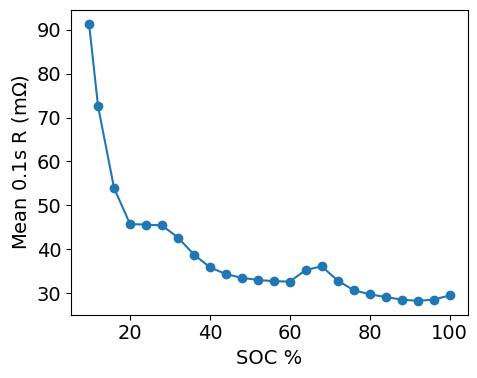

In [11]:
# write a function to get the discharge capacity and resistance
def Get_0p1s_R0(sol_RPT,Index,cap_full):
    Res_0p1s = []; SOC = [100,];
    for i,index in enumerate(Index):
        cycle = sol_RPT.cycles[index]
        Res_0p1s.append(   (
            np.mean(cycle.steps[0]["Terminal voltage [V]"].entries[-10:-1])
            - cycle.steps[1]["Terminal voltage [V]"].entries[0]
        ) / cycle.steps[1]["Current [A]"].entries[0] * 1000)
        if i > 0:
            Dis_Cap = abs(
                cycle.steps[1]["Discharge capacity [A.h]"].entries[0] 
                - cycle.steps[1]["Discharge capacity [A.h]"].entries[-1] )
            SOC.append(SOC[-1]-Dis_Cap/cap_full*100)
    return np.mean(Res_0p1s),Res_0p1s,SOC
cap_full = 5;
Index = np.arange(1,25,1) # index = 2:25
Mean_Res_0p1s,Res_0p1s,SOC = Get_0p1s_R0(sol_GITT,Index,cap_full)

fs=14;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
ax.plot(SOC,Res_0p1s,"-o")
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Mean 0.1s R (m$\Omega$)')
print(SOC[-1],Mean_Res_0p1s,Res_0p1s[-1])

In [24]:
R_C_2_50SOC = np.interp(50,np.flip(SOC_C_2),np.flip(Rohmic_C_2),)
print(R_C_2_50SOC)

29.041655059782016


9.74540401458672 39.46933223626625 91.33672301180091


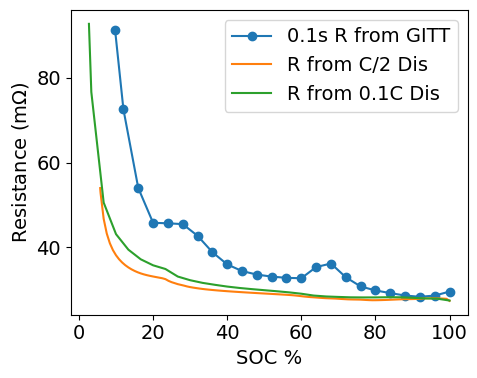

In [18]:
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
ax.plot(SOC,Res_0p1s,"-o",label =r'0.1s R from GITT' )
ax.plot(SOC_C_2,Rohmic_C_2,label=r'R from C/2 Dis')
ax.plot(SOC_C_10,Rohmic_C_10,label=r'R from 0.1C Dis')
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Resistance (m$\Omega$)')
plt.legend()
print(SOC[-1],Mean_Res_0p1s,Res_0p1s[-1])
#ax.set_ylim(20,50)